In [515]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'


In [516]:
import torch
from botorch import fit_gpytorch_model
from botorch.acquisition import UpperConfidenceBound
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns

# 目的関数の用意 (Rosenbrock関数)

In [517]:
def styblinski_tang(x):
    indices = [0, 2, 4, 6, 8]
    x_selected = x[..., indices]
    return 0.5 * torch.sum(x_selected ** 4 - 16 * x_selected ** 2 + 5 * x_selected, dim=-1)

In [518]:
# styblinski_tang関数の最適解
global_optimum = -39.16599 * 25

# 初期点の生成関数

In [519]:
def generate_initial_points(n_initial, dim, bounds):
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]

# モデル作成関数


In [520]:
def create_model(train_X, train_Y):
    kernel = ScaleKernel(RBFKernel(ard_num_dims=train_X.shape[-1], noise_constraint=1e-5))
    model = SingleTaskGP(train_X, train_Y, covar_module=kernel)
    return model


# ドロップアウトベイズクラス

In [521]:
class DropoutMixBO:
    def __init__(self, dim, active_dim, bounds, n_initial,obj_function, dropout_prob=0.1):
        self.dim = dim
        self.active_dim = active_dim
        self.bounds = bounds
        self.obj_function = obj_function
        self.dropout_prob = dropout_prob
        self.X = generate_initial_points(n_initial, dim, bounds)
        self.Y = self.obj_function(self.X)
        self.best_f = self.Y.min().item()
        self.best_x = self.X[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial

    def optimize(self, n_iter):
        for _ in range(n_iter):
            # 全次元からランダムにactive_dim個選ぶ
            active_dims = np.random.choice(self.dim, self.active_dim, replace=False)

            train_X = self.X[:, active_dims]
            train_Y = self.Y.unsqueeze(-1)
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]])
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_active, q=1, num_restarts=5, raw_samples=20,
            )

            x_new = torch.zeros(self.dim)
            if np.random.random() < self.dropout_prob:
                x_new[active_dims] = candidate.squeeze()
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = self.obj_function(x_new.unsqueeze(0))

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])
            self.Y = torch.cat([self.Y, y_new])

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_new

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

# REMBO

In [522]:
class REMBO:
    def __init__(self, high_dim, low_dim, bounds, n_initial, obj_function):
        self.high_dim = high_dim
        self.low_dim = low_dim
        self.bounds = bounds
        self.obj_function = obj_function
        self.X = torch.randn(n_initial, low_dim) * 2 - 1
        self.A = torch.randn(high_dim, low_dim)
        self.X_high = torch.clamp(torch.matmul(self.X, self.A.t()), bounds[0], bounds[1])
        self.Y = self.obj_function(self.X_high)
        self.best_f = self.Y.min().item()
        self.best_x = self.X_high[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial

    def optimize(self, n_iter):
        for _ in range(n_iter):
            # イテレーションごとにランダムな行列を生成
            self.A = torch.randn(self.high_dim, self.low_dim)
            self.X_high = torch.clamp(torch.matmul(self.X, self.A.t()), self.bounds[0], self.bounds[1])
            self.Y = self.obj_function(self.X_high)

            train_X = self.X
            train_Y = self.Y.unsqueeze(-1)
            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_low = torch.stack([torch.ones(self.low_dim) * -1, torch.ones(self.low_dim)])
            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_low, q=1, num_restarts=5, raw_samples=20,
            )

            x_low = candidate.squeeze()
            x_high = torch.clamp(torch.matmul(x_low.unsqueeze(0), self.A.t()), self.bounds[0], self.bounds[1]).squeeze()

            y_new = self.obj_function(x_high.unsqueeze(0))

            self.X = torch.cat([self.X, x_low.unsqueeze(0)])
            self.X_high = torch.cat([self.X_high, x_high.unsqueeze(0)])
            self.Y = torch.cat([self.Y, y_new])

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_high

            self.eval_history.append(self.best_f)

        return self.best_x, self.best_f

# BC-UCBアルゴリズムを取り入れたDropoutMixBO_BCUCBクラス

In [523]:
class DropoutMixBO_BC_UCB:
    def __init__(self, dim, active_dim, bounds, n_initial, obj_function, dropout_prob=0.1, epsilon=0.1,
                 temperature=1e-2, reset_interval=100):
        self.dim = dim
        self.active_dim = active_dim
        self.bounds = bounds
        self.dropout_prob = dropout_prob
        self.obj_function = obj_function
        self.epsilon = epsilon
        self.temperature = temperature
        self.reset_interval = reset_interval
        self.iteration = 0

        initial_X = generate_initial_points(n_initial, dim, bounds)
        initial_Y = obj_function(initial_X)

        self.X = torch.tensor(initial_X, dtype=torch.double)
        self.Y = torch.tensor(initial_Y, dtype=torch.double)

        self.best_f = self.Y.min().item()
        self.best_x = self.X[self.Y.argmin()]
        self.eval_history = [self.best_f] * n_initial
        self.improvement_history = []

        # BC-UCB用の変数
        self.dim_counts = np.zeros(dim)
        self.dim_rewards = np.zeros(dim)
        self.dim_squared_rewards = np.zeros(dim)
        self.total_pulls = 0

        self.arm_selection_history = []  # アーム選択履歴

        self.sigma_history = []  # 各アームの標準偏差の履歴

    def select_active_dims(self):
        self.iteration += 1

        if np.random.random() < max(self.epsilon * np.exp(-self.iteration / 1000), 0.01):  # Decaying epsilon
            selected_arms = np.random.choice(self.dim, self.active_dim, replace=False)
        else:
            empirical_means = self.dim_rewards / (self.dim_counts + 1e-5)
            empirical_vars = self.dim_squared_rewards / (self.dim_counts + 1e-5) - empirical_means ** 2
            empirical_vars = np.maximum(empirical_vars, 1e-5)  # Ensure non-negative variance

            ucb_scores = empirical_means + np.sqrt(
                6 * empirical_vars * np.log(self.total_pulls + 1) / (self.dim_counts + 1e-5)) + 9 * np.log(
                self.total_pulls + 1) / (self.dim_counts + 1e-5)

            # Normalize UCB scores to prevent numerical instability
            ucb_scores = (ucb_scores - np.min(ucb_scores)) / (np.max(ucb_scores) - np.min(ucb_scores) + 1e-10)

            # Softmax selection with temperature annealing
            temperature = max(self.temperature / np.log(self.iteration + 2), 1e-5)  # Annealing schedule
            probabilities = softmax(ucb_scores / temperature)

            # Ensure probabilities sum to 1 and are non-zero
            probabilities = np.clip(probabilities, 1e-10, 1)
            probabilities /= probabilities.sum()

            selected_arms = np.random.choice(self.dim, self.active_dim, replace=False, p=probabilities)

        # Record arm selection
        arm_selection = np.zeros(self.dim)
        arm_selection[selected_arms] = 1
        self.arm_selection_history.append(arm_selection)

        # Periodic reset
        if self.iteration % self.reset_interval == 0:
            self.dim_rewards *= 0.5
            self.dim_counts *= 0.5
            self.dim_squared_rewards *= 0.5

        return selected_arms

    def update_bandit(self, selected_dims, reward):
        self.dim_counts[selected_dims] += 1
        self.dim_rewards[selected_dims] += reward
        self.dim_squared_rewards[selected_dims] += reward**2
        self.total_pulls += 1

        # Thompson Sampling update with safeguards
        alpha = np.maximum(self.dim_rewards - np.min(self.dim_rewards) + 1, 1e-6)
        beta = np.maximum(self.dim_counts - self.dim_rewards + np.min(self.dim_rewards) + 1, 1e-6)
        self.thompson_samples = np.random.beta(alpha, beta)

    def optimize(self, n_iter):
        for _ in range(n_iter):
            active_dims = self.select_active_dims()

            train_X = self.X[:, active_dims]
            train_Y = self.Y.unsqueeze(-1)

            model = create_model(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            fit_gpytorch_model(mll)

            UCB = UpperConfidenceBound(model, beta=0.1)
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]]).double()

            candidate, _ = optimize_acqf(
                UCB, bounds=bounds_active, q=1, num_restarts=10, raw_samples=100,
                options={"maxiter": 200, "batch_limit": 5}
            )

            x_new = torch.zeros(self.dim, dtype=torch.double)
            if np.random.random() < self.dropout_prob:
                x_new[active_dims] = candidate.squeeze()
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)
                x_new[inactive_dims] = self.X[np.random.randint(self.X.shape[0]), inactive_dims]
            else:
                x_new[active_dims] = candidate.squeeze()
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = self.obj_function(x_new.unsqueeze(0))

            sigmas = []

            with torch.no_grad():
                pred = model(x_new[active_dims].unsqueeze(0))
            mu = pred.mean.item()
            sigma = pred.stddev.item()

            improvement = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-((mu - y_new.item()) ** 2) / (2 * sigma ** 2))
            sigmas.append(sigma)

            self.sigma_history.append(sigmas)
            self.update_bandit(active_dims, improvement)
            self.improvement_history.append(improvement)  # 平均改善度を記録

            if y_new < self.best_f:
                self.best_f = y_new.item()
                self.best_x = x_new

            self.eval_history.append(self.best_f)

        # Convert arm selection history to DataFrame
        self.arm_selection_df = pd.DataFrame(self.arm_selection_history,
                                             columns=[f'Arm_{i}' for i in range(self.dim)])
        self.arm_selection_df.index.name = 'Iteration'

        return self.best_x, self.best_f

    def save_arm_selection_history(self, filename):
        self.arm_selection_df.to_csv(filename)

    def plot_sigma_history(self):
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(self.sigma_history) + 1), self.sigma_history)
        plt.xlabel('Iteration')
        plt.ylabel('Predicted Standard Deviation')
        plt.title('Predicted Standard Deviation vs Iteration')
        plt.grid(True)
        plt.show()

# 最適化の実行


In [524]:
dim = 10
active_dim = 5
bounds = torch.tensor([[-5.0] * dim, [5.0] * dim])
n_initial = 200
n_iter = 100

In [525]:
dropout_bo_mix = DropoutMixBO(dim, active_dim, bounds, n_initial, styblinski_tang, dropout_prob=0.1)
dropout_bo_copy = DropoutMixBO(dim, active_dim, bounds, n_initial, styblinski_tang, dropout_prob=0.0)
dropout_bo_random = DropoutMixBO(dim, active_dim, bounds, n_initial, styblinski_tang, dropout_prob=1.0)
dropout_bandit_bc_ucb = DropoutMixBO_BC_UCB(dim, active_dim, bounds, n_initial, styblinski_tang, dropout_prob=0.0)
rembo = REMBO(dim, active_dim, bounds, n_initial, styblinski_tang)

C:\Users\nomuyu\AppData\Local\Temp\ipykernel_35244\3485831268.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(initial_X, dtype=torch.double)
C:\Users\nomuyu\AppData\Local\Temp\ipykernel_35244\3485831268.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(initial_Y, dtype=torch.double)


In [526]:
try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      dropout_mix_best_x , dropout_mix_best_f = dropout_bo_mix.optimize(n_iter)
      pbar.update(20)
      dropout_copy_best_x , dropout_copy_best_f = dropout_bo_copy.optimize(n_iter)
      pbar.update(20)
      dropout_random_best_x , dropout_random_best_f = dropout_bo_random.optimize(n_iter)
      pbar.update(20)
      rembo_best_x, rembo_best_f = rembo.optimize(n_iter)
      pbar.update(20) 
      pbar.update(10)
      dropout_bandit_bc_ucb_best_x, dropout_bandit_bc_ucb_best_f = dropout_bandit_bc_ucb.optimize(n_iter)
      dropout_bandit_bc_ucb.save_arm_selection_history('dropout_bandit_bc_ucb_arm_selection_binary.csv')
      pbar.update(10)
    
except subprocess.CalledProcessError:
  print(captured)
  raise

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

## アームの履歴 BC_UCBのバンディット

           Arm_0  Arm_1  Arm_2  Arm_3  Arm_4  Arm_5  Arm_6  Arm_7  Arm_8  \
Iteration                                                                  
0            1.0    0.0    1.0    0.0    0.0    1.0    1.0    0.0    0.0   
1            1.0    1.0    1.0    0.0    0.0    1.0    0.0    0.0    0.0   
2            0.0    0.0    0.0    1.0    1.0    1.0    0.0    1.0    1.0   
3            0.0    1.0    0.0    1.0    1.0    0.0    1.0    1.0    0.0   
4            1.0    0.0    0.0    0.0    0.0    1.0    1.0    1.0    1.0   

           Arm_9  
Iteration         
0            1.0  
1            1.0  
2            0.0  
3            0.0  
4            0.0  


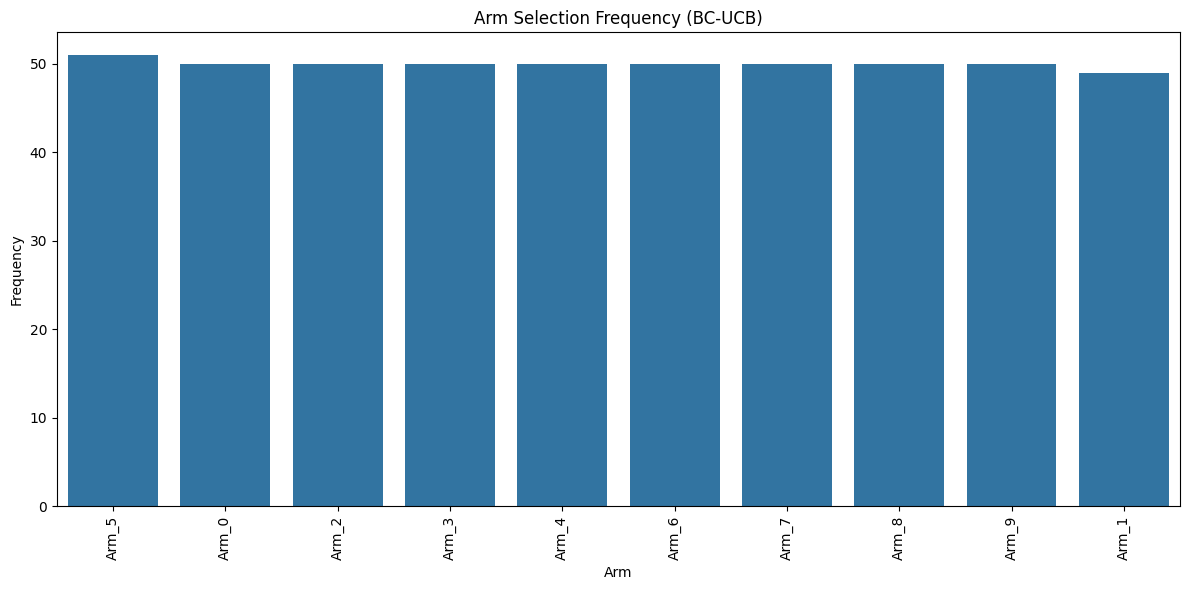

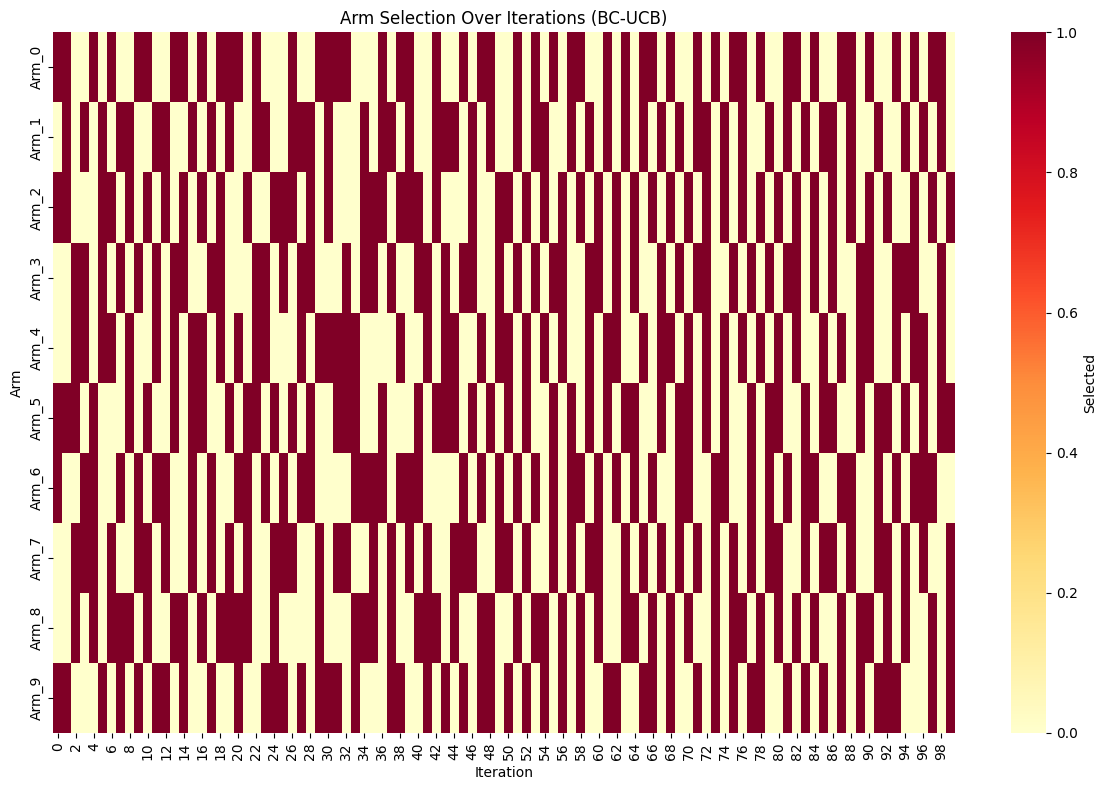

In [527]:
# Load the saved CSV file
df = pd.read_csv("dropout_bandit_bc_ucb_arm_selection_binary.csv", index_col="Iteration")

# Display the first few rows of the DataFrame
print(df.head())

# Calculate arm selection frequency
arm_freq = df.sum().sort_values(ascending=False)

# Create a bar plot of arm selection frequency
plt.figure(figsize=(12, 6))
sns.barplot(x=arm_freq.index, y=arm_freq.values)
plt.title("Arm Selection Frequency (BC-UCB)")
plt.xlabel("Arm")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Create a heatmap of arm selection over iterations
plt.figure(figsize=(12, 8))
sns.heatmap(df.T, cmap="YlOrRd", cbar_kws={'label': 'Selected'})
plt.title("Arm Selection Over Iterations (BC-UCB)")
plt.xlabel("Iteration")
plt.ylabel("Arm")
plt.tight_layout()
plt.show()

## Dropout_Banditのimprovementのプロット

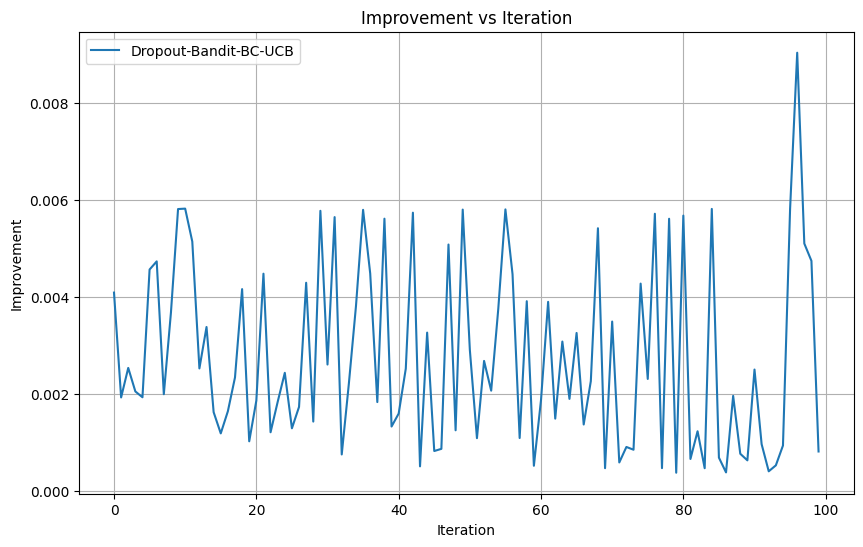

In [528]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(dropout_bandit_bc_ucb.improvement_history)), dropout_bandit_bc_ucb.improvement_history, label='Dropout-Bandit-BC-UCB')
plt.xlabel('Iteration')
plt.ylabel('Improvement')
plt.title('Improvement vs Iteration')
plt.legend()
plt.grid(True)
plt.show()

## Dropout_Banditのsigmaのプロット

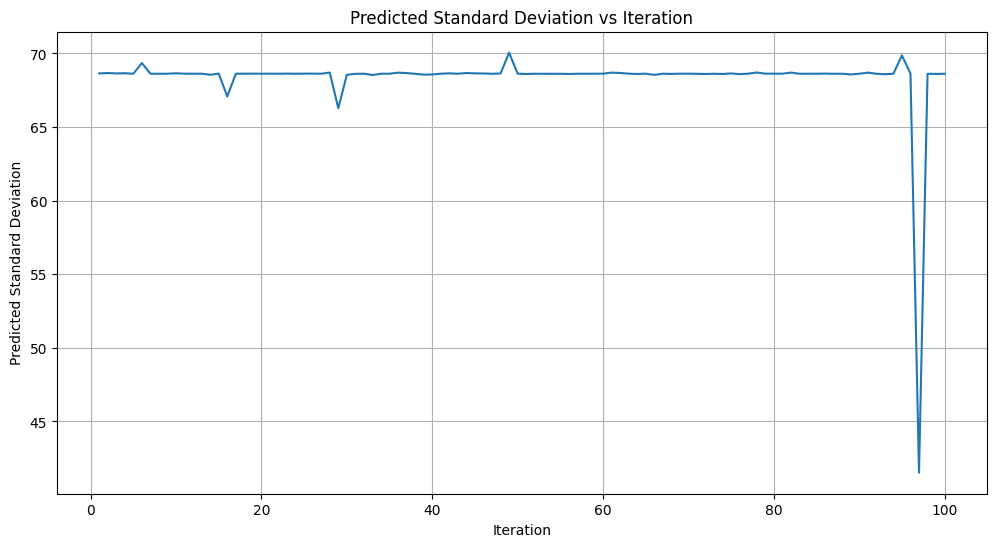

In [529]:
dropout_bandit_bc_ucb.plot_sigma_history()

# 結果のプロット

C:\Users\nomuyu\Documents\baysian_optimization\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


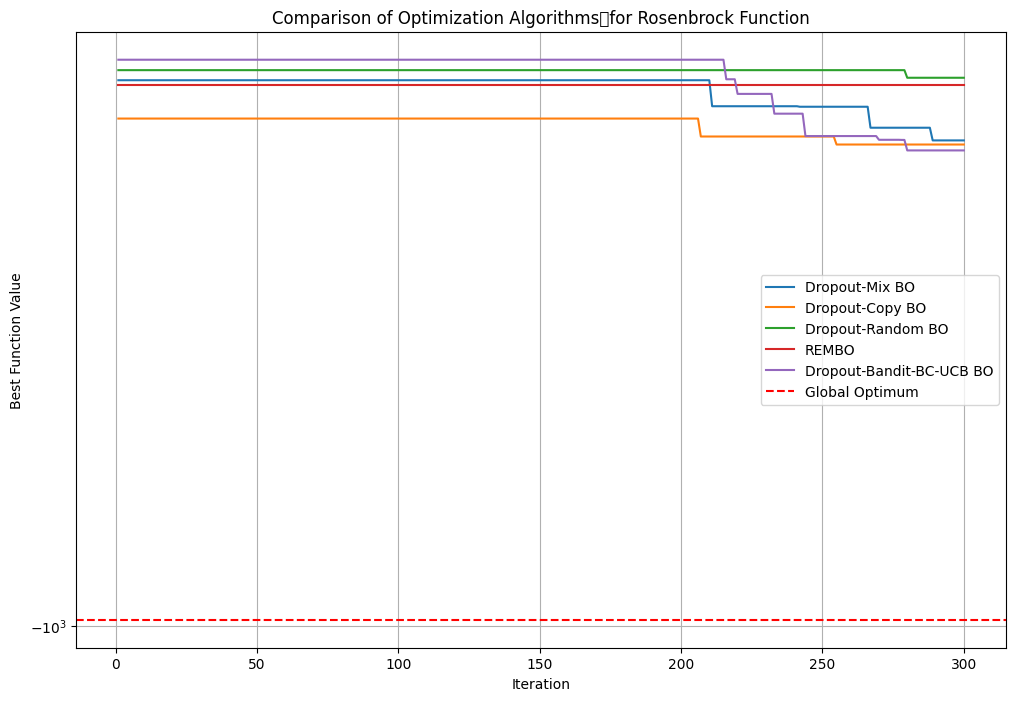

In [530]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_mix.eval_history, label='Dropout-Mix BO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_copy.eval_history, label='Dropout-Copy BO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bo_random.eval_history, label='Dropout-Random BO')
plt.plot(range(1, n_initial + n_iter + 1), rembo.eval_history, label='REMBO')
plt.plot(range(1, n_initial + n_iter + 1), dropout_bandit_bc_ucb.eval_history, label='Dropout-Bandit-BC-UCB BO')
plt.axhline(y=global_optimum, color='r', linestyle='--', label='Global Optimum')
plt.xlabel('Iteration')
plt.ylabel('Best Function Value')
plt.title('Comparison of Optimization Algorithms　for Rosenbrock Function')
plt.legend()
plt.yscale('symlog')
plt.grid(True)
plt.show()